### 주차수요 예측 AI 경진대회

🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측



ref: https://dacon.io/competitions/official/235745/data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,628 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and d

In [4]:
import os

os.chdir('/content/drive/MyDrive/workspace/DACON/주차수요 예측')

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
age_gender = pd.read_csv('dataset/age_gender_info.csv')

In [8]:
train.shape, test.shape, age_gender.shape

((2952, 15), (1022, 14), (16, 23))

In [9]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [11]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

## 전처리

### 결측치 확인

In [12]:
train.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
신분            0
임대보증금       569
임대료         569
지하철         211
버스            4
단지내주차면수       0
등록차량수         0
dtype: int64

In [15]:
train[train['임대보증금'].isna()]['신분'].unique()

array(['D'], dtype=object)

In [16]:
train[train['신분'] == 'D'].count()

단지코드        569
총세대수        569
임대건물구분      569
지역          569
공급유형        569
전용면적        569
전용면적별세대수    569
공가수         569
신분          569
임대보증금         0
임대료           0
지하철         435
버스          569
단지내주차면수     569
등록차량수       569
dtype: int64

D유형은 모두 임대보증금과 임대료가 null값

In [17]:
train.fillna(0, inplace=True)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   신분        2952 non-null   object 
 9   임대보증금     2952 non-null   object 
 10  임대료       2952 non-null   object 
 11  지하철       2952 non-null   float64
 12  버스        2952 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.1+ KB


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


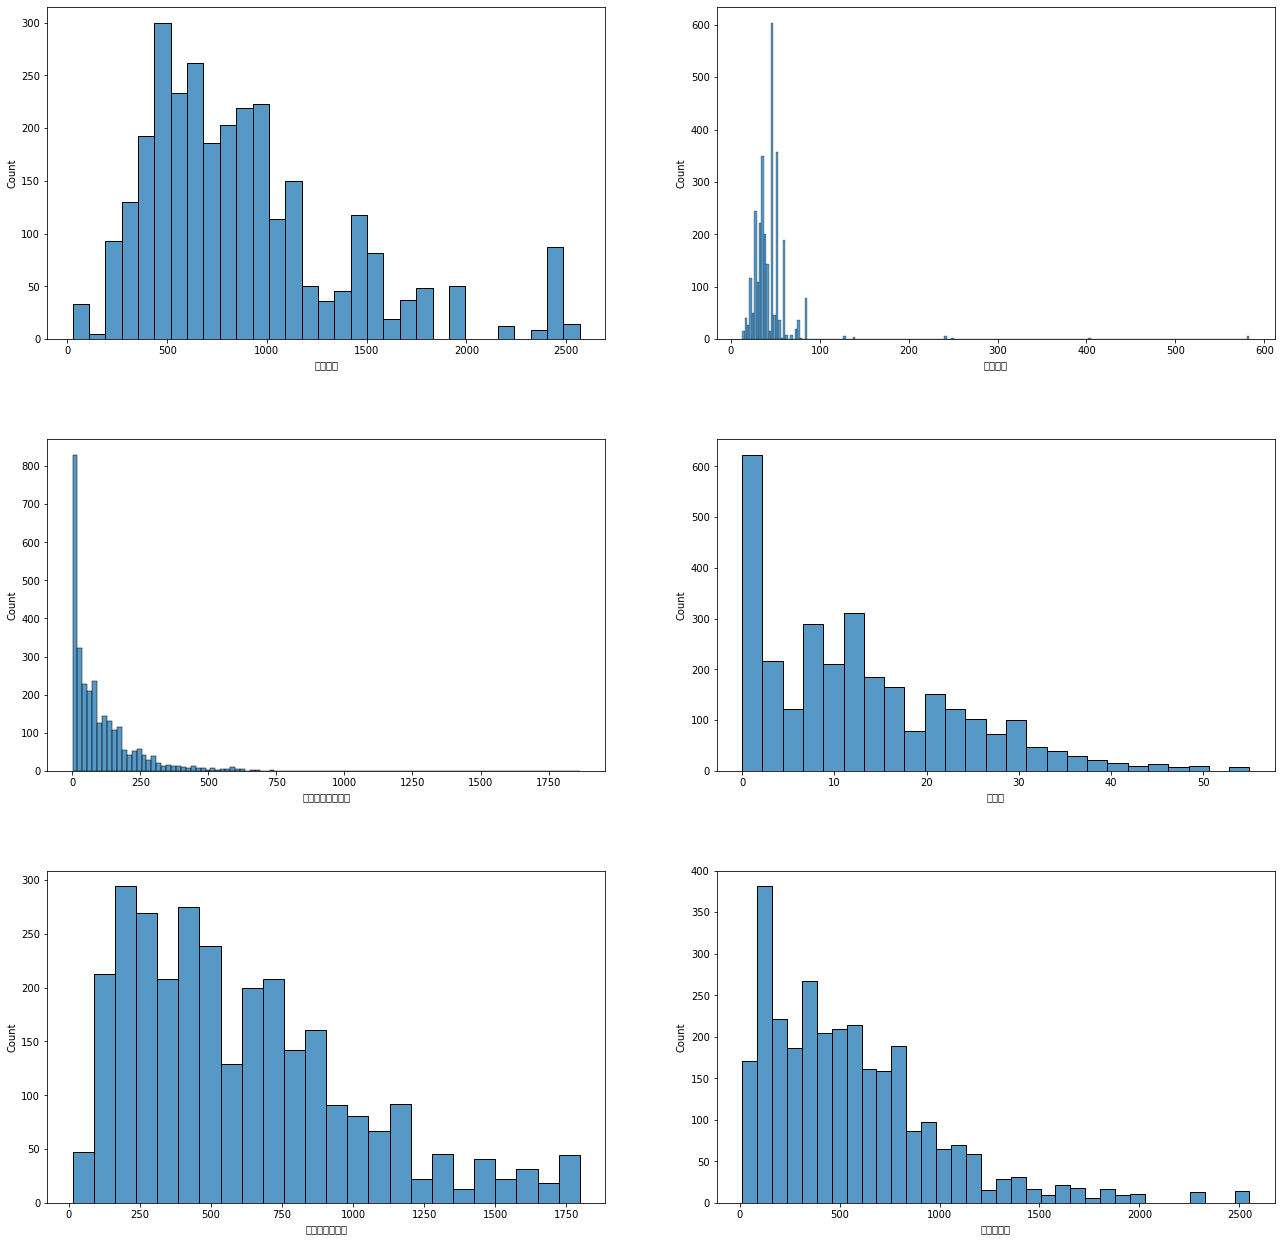

In [19]:
fig = plt.figure(figsize=(22, 22))

numeric_cols = ['총세대수', '전용면적', '전용면적별세대수', '공가수', '단지내주차면수', '등록차량수']

for i, n in enumerate(numeric_cols):
    plt.subplot(3, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n])

#### 지역명 숫자로 매핑

In [33]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i

train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

#### 전용면적을 5의 배수로 변경

In [22]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

In [23]:
train['전용면적'].unique()

array([ 35.,  50.,  55.,  30.,  45.,  40.,  25.,  70.,  10.,  15.,  20.,
       315.,  60., 135.,  75., 105., 580., 125., 240., 400., 245., 405.,
        80.,  65.])

#### 전용면적 상/하한 적용
상한100, 하한 15

In [24]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15
idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

In [25]:
test['전용면적'].unique()

array([ 35.,  45.,  50.,  30.,  55.,  25.,  75., 100.,  15.,  20.,  40.,
        60.,  80.,  70.])

#### 단지별 데이터 1차원으로 취합

In [35]:
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [36]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [37]:
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

423it [00:09, 43.68it/s]
150it [00:03, 44.16it/s]


In [38]:
new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_35.0,면적_50.0,면적_55.0,면적_30.0,면적_45.0,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,38.0,0.0,1425.0,0.0,3.0,149.0,665.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,1.0,624.0,0.0,3.0,80.0,132.0,0.0,276.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,2.0,1285.0,1.0,1.0,0.0,124.0,0.0,390.0,340.0,362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,3.0,734.0,1.0,3.0,240.0,303.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,4.0,645.0,0.0,2.0,254.0,246.0,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,90.0,7.0,9.0,66.0,0.0,3.0,36.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
419,C2035,492.0,24.0,5.0,521.0,0.0,1.0,156.0,0.0,0.0,0.0,180.0,0.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
420,C2020,40.0,7.0,8.0,25.0,1.0,2.0,15.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
421,C2437,90.0,12.0,11.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,16.0


#### 결측치 처리

In [39]:
new_train = new_train.fillna(-1)
new_test = new_test.fillna(-1)

#### 학습

In [41]:
x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

In [44]:
model = RandomForestRegressor(n_jobs=-1, random_state=435)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=435, verbose=0, warm_start=False)

#### 예측 및 제출

In [45]:
pred = model.predict(x_test)

In [50]:
submission = pd.read_csv('./dataset/sample_submission.csv')

submission['num'] = pred
submission.to_csv('submission/rfr_sub.csv', index=False)